In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torchvision.models import *

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [2]:
# general settings

# device
device = torch.device('cuda' if use_gpu else 'cpu')

# batchsize
batchsize = 64

# seed setting (warning : cuDNN's randomness is remaining)
seed = 1
torch.manual_seed(seed)
if use_gpu:
    torch.cuda.manual_seed(seed)
    
# directory settings
# Data directory (for IR-MNIST)
data_dir = '../../data/IR-MNIST/'
train_data_dir = data_dir + 'Train_Samples/'
test_data_dir = data_dir + 'Test_Samples/'

# directory to put generated images
output_dir = data_dir + 'output/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# directory to save state_dict and loss.npy
save_dir = data_dir + 'save/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [3]:
# make dataset class for image loading
class MyDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.list_dir = os.listdir(root_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.list_dir)
    
    def __getitem__(self, idx):
        img_name = self.root_dir + self.list_dir[idx]
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [4]:
# define transforms
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
train_loss_list = np.load(save_dir + 'train_loss_list_use_densenet121.npy')
validation_loss_list = np.load(save_dir + 'validation_loss_list_use_densenet121.npy')

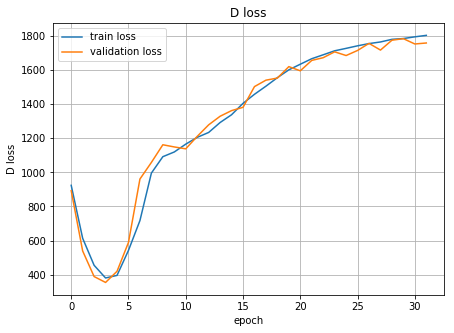

In [7]:
# visualize training log
plt.figure(figsize = (7,5))
plt.plot(train_loss_list[0], label = 'train loss')
plt.plot(validation_loss_list[0], label = 'validation loss')
plt.title('D loss')
plt.xlabel('epoch')
plt.ylabel('D loss')
plt.legend()
plt.grid()
plt.show()

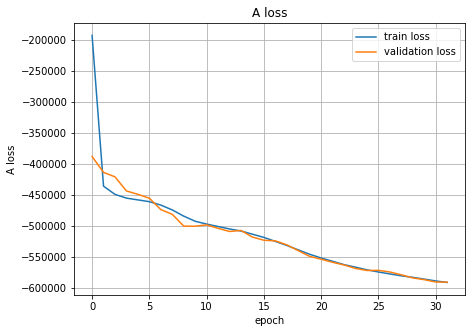

In [8]:
# visualize training log
plt.figure(figsize = (7,5))
plt.plot(train_loss_list[1], label = 'train loss')
plt.plot(validation_loss_list[1], label = 'validation loss')
plt.title('A loss')
plt.xlabel('epoch')
plt.ylabel('A loss')
plt.legend()
plt.grid()
plt.show()

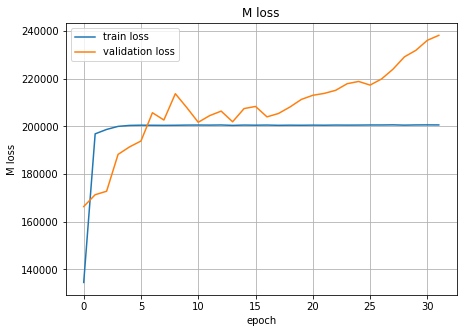

In [10]:
# visualize training log
plt.figure(figsize = (7,5))
plt.plot(train_loss_list[2], label = 'train loss')
plt.plot(validation_loss_list[2], label = 'validation loss')
plt.title('M loss')
plt.xlabel('epoch')
plt.ylabel('M loss')
plt.legend()
plt.grid()
plt.show()

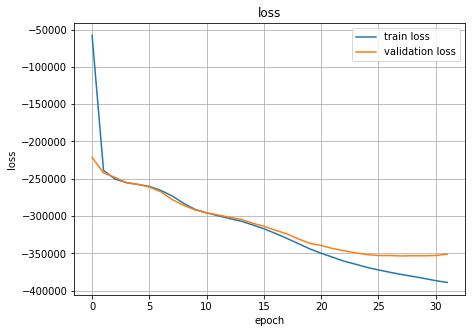

In [11]:
# visualize training log
plt.figure(figsize = (7,5))
plt.plot(np.sum(train_loss_list, axis = 0), label = 'train loss')
plt.plot(np.sum(validation_loss_list, axis = 0), label = 'validation loss')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [28]:
# make dataset
testDataset = MyDataset(test_data_dir, transform = tf)
test_loader = DataLoader(testDataset, batch_size = batchsize, shuffle = True)

In [29]:
# visualization of an example of training data
# comment out when runnnig in no GUI machine
def show_image(tensor_image):
    np_image = tensor_image.numpy()
    np_image = np.transpose(np_image, [1, 2, 0]) * 0.5 + 0.5
    plt.imshow(np_image)

In [30]:
# densenet121 for feature extraction
class mydensenet121(nn.Module):
    def __init__(self):
        super(mydensenet121, self).__init__()
        densenet_pretrained = densenet121(pretrained = True)
        self.features = densenet_pretrained.features[:5]
        self.bn_relu_1x1conv = densenet_pretrained.features[5][:3]
    
    def forward(self, x):
        out = self.features(x)
        out = self.bn_relu_1x1conv(out)
        return out

In [31]:
# define downsampling parts for convenience
class Downsampler(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 4, ssize = 2, psize = 1):
        super(Downsampler, self).__init__()
        self.cv = nn.Conv2d(in_channels, out_channels, kernel_size = ksize, stride = ssize, padding = psize)
        self.bn = nn.BatchNorm2d(out_channels)
        self.rl = nn.ReLU()
        
    def forward(self, x):
        out = self.cv(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

In [32]:
# define upsampling parts for convenience
class Upsampler(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 4, ssize = 2, psize = 1):
        super(Upsampler, self).__init__()
        self.tc = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = ksize, stride = ssize, padding = psize)
        self.bn = nn.BatchNorm2d(out_channels)
        self.rl = nn.ReLU()
        
    def forward(self, x):
        out = self.tc(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

In [33]:
# define VAE Encoder
class Encoder(nn.Module):
    def __init__(self, n_z):
        super(Encoder, self).__init__()
        self.cv1 = Downsampler(128, 256) # out tensor size : (batchsize, 256, 28, 28)
        self.cv2 = Downsampler(256, 256) # out tensor size : (batchsize, 256, 14, 14)
        self.cv3 = Downsampler(256, 512) # out tensor size : (batchsize, 512,  7,  7)
        
        self.fc4_mean   = nn.Linear(512*7*7, n_z)
        self.fc4_logvar = nn.Linear(512*7*7, n_z)
    
    def forward(self, x):
        out = self.cv1(x)
        out = self.cv2(out)
        out = self.cv3(out)
        
        out = out.view(out.size(0), -1)
        
        out_mean   = self.fc4_mean(out)
        out_logvar = self.fc4_logvar(out)
        
        return out_mean, out_logvar

In [34]:
# define VAE Decoder
class Decoder(nn.Module):
    def __init__(self, n_z):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(n_z, 512*7*7)
        self.tc2 = Upsampler(512, 256)   # out tensor size : (batchsize, 256, 14, 14)
        self.tc3 = Upsampler(256, 256)   # out tensor size : (batchsize, 256, 28, 28)
        self.tc4_mean    = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1) # (bsize, 128, 56, 56)
        self.tc4_logvar  = nn.ConvTranspose2d(256, 128, kernel_size = 4, stride = 2, padding = 1) # (bsize, 128, 56, 56)
    
    def forward(self, x):
        out = self.fc1(x)
        
        out = out.view(out.size(0), 512, 7, 7)
        
        out = self.tc2(out)
        out = self.tc3(out)
        out_mean = self.tc4_mean(out)
        out_logvar  = self.tc4_logvar(out)
        
        return out_mean, out_logvar

In [35]:
class VAE(nn.Module):
    def __init__(self, n_z):
        super(VAE, self).__init__()
        self.encoder = Encoder(n_z)
        self.decoder = Decoder(n_z)
        
    def forward(self, x):
        embed_mean, embed_logvar = self.encoder(x)
        
        eps = torch.randn(embed_mean.size()).to(device)
        z = (0.5 * embed_logvar).exp() * eps + embed_mean
        
        out_mean, out_logvar = self.decoder(z)
        
        return out_mean, out_logvar, embed_mean, embed_logvar

In [41]:
# prepare network and optimizer
n_z = 500
net = VAE(n_z)

params = torch.load(save_dir + 'VAE_IR_MNIST_use_densenet121.pth')
net.load_state_dict(params)

feature_extractor = mydensenet121()

net.to(device)
feature_extractor.to(device)

/home/kaito/.local/lib/python3.5/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


mydensenet121(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(i

In [99]:
# make dataset
normaldataset = MyDataset(train_data_dir, transform = tf)

# split into training data and validation data
train_data, normal_data = train_test_split(normaldataset, test_size = 0.2, random_state = seed)

normal_loader = DataLoader(normal_data, batch_size = batchsize, shuffle = True)

In [112]:
# define loss functions
def loss_D(embed_mean, embed_logvar):
    loss_d = 0.5 * (-embed_logvar - 1 + embed_logvar.exp() + embed_mean.pow(2))
    return loss_d

def loss_A(out_logvar):
    log2pi = float(np.log(2*np.pi))
    loss_a = 0.5 * (log2pi + out_logvar)
    return loss_a
    
def loss_M(out_mean, out_logvar, in_x):
    loss_m = 0.5 * ( (out_mean - in_x).pow(2) / out_logvar.exp() )
    return loss_m

In [113]:
test_data = iter(test_loader).next()
test_data = test_data.to(device)

In [114]:
net.eval()
feature_extractor.eval()

with torch.no_grad():
    test_feature = feature_extractor(test_data)
    out_mean, out_logvar, embed_mean, embed_logvar = net(test_feature)

In [115]:
loss_d = loss_D(embed_mean, embed_logvar)
loss_a = loss_A(out_logvar)
loss_m = loss_M(out_mean, out_logvar, test_feature)

In [116]:
loss_m.size()

torch.Size([64, 128, 56, 56])

In [117]:
abnormal_data = loss_m.sum(dim=1).max(dim = 1)[0].max(dim=1)[0].cpu().numpy()

In [118]:
normal_data = iter(normal_loader).next()
normal_data = normal_data.to(device)

In [119]:
with torch.no_grad():
    normal_feature = feature_extractor(normal_data)
    out_mean2, out_logvar2, embed_mean2, embed_logvar2 = net(normal_feature)

In [120]:
loss_d2 = loss_D(embed_mean2, embed_logvar2)
loss_a2 = loss_A(out_logvar2)
loss_m2 = loss_M(out_mean2, out_logvar2, normal_feature)

In [121]:
normal_data = loss_m2.sum(dim=1).max(dim = 1)[0].max(dim=1)[0].cpu().numpy()

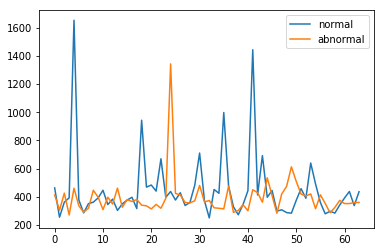

In [122]:
plt.plot(normal_data, label = 'normal')
plt.plot(abnormal_data, label = 'abnormal')
plt.legend()
plt.show()